In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [3]:
# Forward Euler Method for ODEs
def forward_euler(v, u, I, dt, threshold_potential):
    for i in range(1, len(time)):
        # Compute new values for v and u using the Forward Euler method
        v[i] = v[i - 1][0] + dt * membrane_potential(v[i - 1][0], u[i - 1][0], I[i][0])
        u[i] = u[i - 1][0] + dt * membrane_recovery(v[i - 1][0], u[i - 1][0])

        # Implement the threshold reset
        if v[i] > threshold_potential:
            v[i] = c
            u[i] = u[i] + d
    return v, u


# Runge-Kutta 4th Order Method for ODEs
def runge_kutta_4(v, u, I, dt, threshold_potential):
    for i in range(1, len(time)):
        # k1 for v and u
        k1_v = membrane_potential(v[i - 1][0], u[i - 1][0], I[i][0])
        k1_u = membrane_recovery(v[i - 1][0], u[i - 1][0])

        # k2 for v and u
        v_temp = v[i - 1][0] + 0.5 * k1_v * dt
        u_temp = u[i - 1][0] + 0.5 * k1_u * dt
        k2_v = membrane_potential(v_temp, u_temp, I[i][0])
        k2_u = membrane_recovery(v_temp, u_temp)

        # k3 for v and u
        v_temp = v[i - 1][0] + 0.5 * k2_v * dt
        u_temp = u[i - 1][0] + 0.5 * k2_u * dt
        k3_v = membrane_potential(v_temp, u_temp, I[i][0])
        k3_u = membrane_recovery(v_temp, u_temp)

        # k4 for v and u
        v_temp = v[i - 1][0] + k3_v * dt
        u_temp = u[i - 1][0] + k3_u * dt
        k4_v = membrane_potential(v_temp, u_temp, I[i][0])
        k4_u = membrane_recovery(v_temp, u_temp)

        # Update v and u
        v[i] = v[i - 1][0] + (dt / 6) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
        u[i] = u[i - 1][0] + (dt / 6) * (k1_u + 2 * k2_u + 2 * k3_u + k4_u)

        # Implement the threshold reset
        if v[i] > threshold_potential:
            v[i] = c
            u[i] = u[i] + d
    return v, u


# Function to use with fsolve for the Trapezoidal method
def trapezoidal_fsolve(v_u, v_prev, u_prev, I, dt):
    v, u = v_u
    # Trapezoidal formulas for v and u
    fv = v - v_prev - (dt/2) * (membrane_potential(v_prev, u_prev, I) + membrane_potential(v, u, I))
    fu = u - u_prev - (dt/2) * (membrane_recovery(v_prev, u_prev) + membrane_recovery(v, u))
    return fv, fu

# Trapezoidal Method for ODEs
def trapezoidal_method(v, u, I, dt, theshold_potential):
    for i in range(1, len(time)):
        # Predict v and u using Euler's method for initial guess
        v_guess = v[i - 1][0] + dt * membrane_potential(v[i - 1][0], u[i - 1][0], I[i][0])
        u_guess = u[i - 1][0] + dt * membrane_recovery(v[i - 1][0], u[i - 1][0])

        # Use fsolve to correct the prediction and get the next v and u
        v[i], u[i] = fsolve(trapezoidal_fsolve, [v_guess, u_guess], args=(v[i - 1][0], u[i - 1][0], I[i][0], dt))

        # Implement the threshold reset
        if v[i] > threshold_potential:
            v[i] = c
            u[i] = u[i] + d
    return v, u

## Tonic Bursting

In [4]:
#setup initial parameters (RS)
a, b, c, d = 0.02, 0.20, -50, 2

timestep = .25*(10**-3) #.5 ms
start_time = 0 
end_time = 400

initial_membrane_potential = c
initial_membrane_recovery = b*c
threshold_potential = 30

#time index
time= np.linspace(start = start_time, stop = end_time, num = int((end_time-start_time)/timestep)+1)

#set up mesh functions
n = len(time)
v_num = initial_membrane_potential*np.ones(shape = (n,1)) #numerical approximation values
u_num = initial_membrane_recovery*np.ones(shape = (n,1)) #numerical approximation values

In [7]:
#update functions
membrane_potential = lambda v, u, I: 0.04*(v ** 2) + 5*v + 140 - u + I
membrane_recovery = lambda v,u: a*(b*v - u)

In [8]:
#define INPUT Current
I = np.zeros(shape = (n,1))
I[int(len(I)/8):-1] = 15

In [9]:
# Run the simulation using FE Method

v_forward_euler, u_forward_euler = forward_euler(v_num.copy(), u_num.copy(), I, timestep, threshold_potential)

# Run the simulation using Runge-Kutta 4th Order method
v_runge_kutta, u_runge_kutta = runge_kutta_4(v_num.copy(), u_num.copy(), I, timestep, threshold_potential)

# Run the simulation using the Trapezoidal method

v_trapezoidal, u_trapezoidal = trapezoidal_method(v_num, u_num, I, timestep, threshold_potential)

/home/nand/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


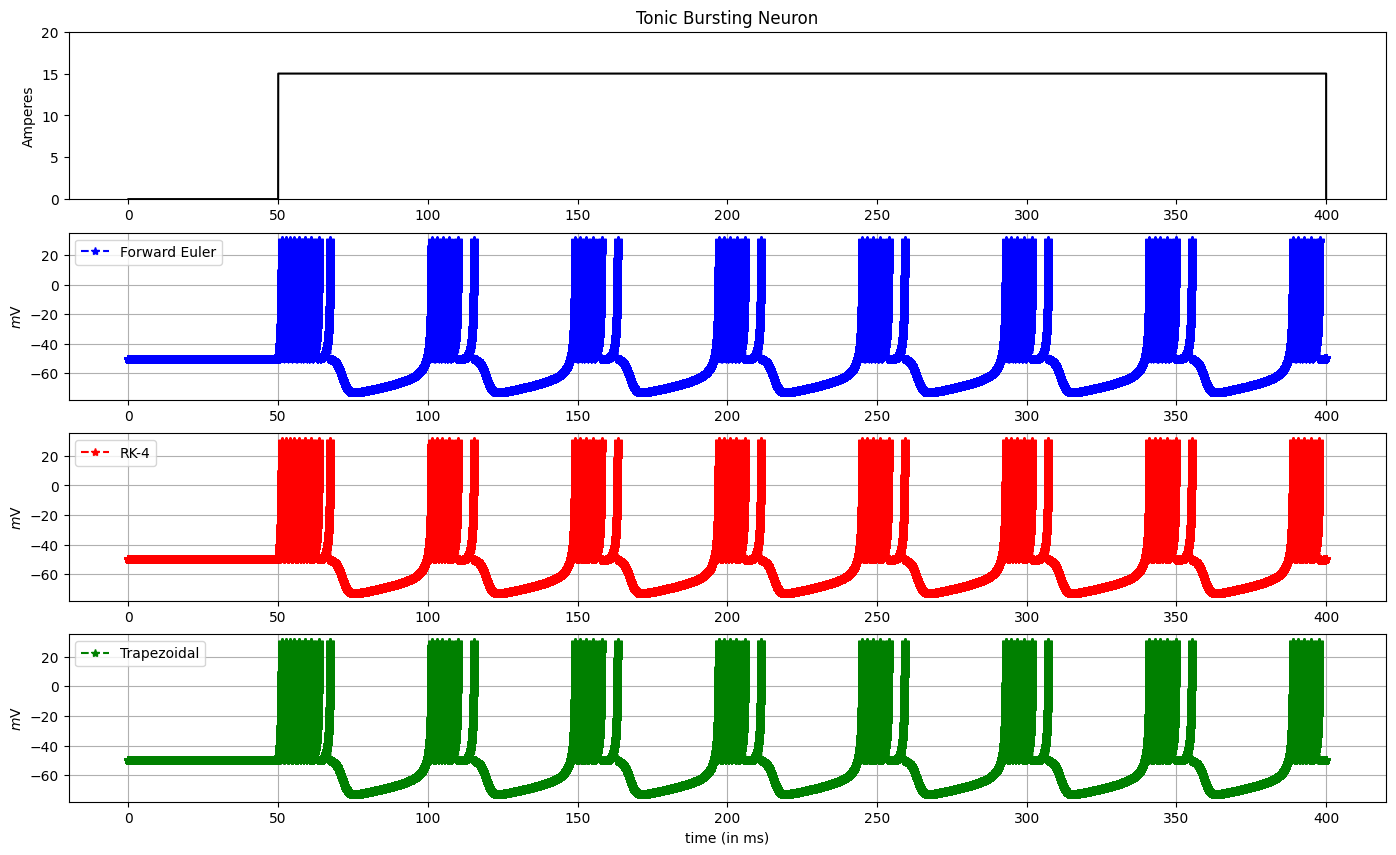

In [12]:
# Plot 

fig, axes = plt.subplots(4, 1, figsize = (17, 10)) 

axes[0].plot(time, I, color = "black")
axes[1].plot(time, v_forward_euler[:n], color = 'blue', marker = '*', linestyle='dashed', label = 'Forward Euler')
axes[2].plot(time, v_runge_kutta[:n], color = 'red', marker = '*', linestyle='dashed', label = 'RK-4')
axes[3].plot(time, v_trapezoidal[:n], color = 'green', marker = '*', linestyle='dashed', label = 'Trapezoidal')



#axes.plot(x, y_exact, color = 'blue', marker = '.', linestyle='dashed', label = r'$y_{exact}$')

axes[0].set_title(r'Tonic Bursting Neuron')
axes[0].set_ylim(bottom=0, top=20)
axes[3].set_xlabel("time (in ms)")
axes[0].set_ylabel("Amperes")
axes[3].set_ylabel(r'$m$V')
axes[2].set_ylabel(r'$m$V')
axes[1].set_ylabel(r'$m$V')
axes[1].grid(True)
axes[2].grid(True)
axes[3].grid(True)
axes[1].legend(loc="upper left")
axes[2].legend(loc="upper left")
axes[3].legend(loc="upper left")


fig.savefig('./figs/tb.png',format='png')